### load necessary modules

In [1]:
import uproot
import awkward as ak
import vector
vector.register_awkward()
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import math
import itertools
import os
from typing import Dict, List, Tuple
from numpy.typing import ArrayLike
import numpy as np
import correctionlib
import awkward as ak
import fastjet
from coffea.nanoevents.methods import vector
from coffea import nanoevents
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.analysis_tools import Weights, PackedSelection
from hist import Hist
ak.behavior.update(vector.behavior)
import sys
sys.path.append('/home/pku/zhaoyz/Higgs/LundReweighting/utils')
from LundReweighter import *
# import pandas as pd


Welcome to JupyROOT 6.28/00


### Load signal NanoAOD files and do pre-selection 

In [2]:
events = nanoevents.NanoEventsFactory.from_root(
        "/data/bond/zhaoyz/CustNano/HWWPFNano/2018/ttbar/Semileptonic_MERGED/MERGED.root",
        schemaclass=nanoevents.NanoAODSchema,
    ).events()

In [3]:
frac = 0.7
n_use = int(frac*len(events))
events_1 = events[:n_use]

In [4]:
#quick look at the fields of loaded files
events_1.fields

['DeepMETResponseTune',
 'fixedGridRhoFastjetAll',
 'SoftActivityJetNjets2',
 'FsrPhoton',
 'LHE',
 'OtherPV',
 'boostedTau',
 'PFCands',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'MET',
 'SoftActivityJetHT2',
 'SoftActivityJetHT5',
 'RawPuppiMET',
 'L1Reco',
 'GenIsolatedPhoton',
 'FatJetPFCands',
 'HLT',
 'GenSubJetAK15',
 'L1PreFiringWeight',
 'Electron',
 'SoftActivityJetNjets10',
 'JetSVs',
 'TkMET',
 'LHEWeight',
 'Flag',
 'L1simulation',
 'LHEPdfWeight',
 'HLTriggerFinalPath',
 'PSWeight',
 'SoftActivityJetNjets5',
 'GenDressedLepton',
 'ChsMET',
 'genTtbarId',
 'FatJetSVs',
 'GenCands',
 'RawMET',
 'FatJet',
 'SoftActivityJetHT',
 'fixedGridRhoFastjetCentralCalo',
 'genWeight',
 'GenVtx',
 'HLTriggerFirstPath',
 'Jet',
 'GenPart',
 'JetPFCands',
 'GenJetSVs',
 'LHEScaleWeight',
 'DeepMETResolutionTune',
 'TrigObj',
 'event',
 'SubJet',
 'AK15Puppi',
 'GenJet',
 'SV',
 'PV',
 'GenVisTau',
 'AK15PuppiSubJet',
 'IsoTrack',
 'SoftActivityJet',
 'Generator',
 'GenJetAK15',
 'GenF

In [5]:
del events

In [6]:
events_1

<NanoEventsArray [<event 1:363751:363750001>, ... ] type='6951000 * event'>

### Define necessary functions to run the selection

In [7]:
#pad array with given value
def pad_val(
    arr: ak.Array,
    target: int,
    value: float, #value can also be Bool variable 
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    padded_arr = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    # pad_none will fill the array to target length with "None" for dedicated axis
    # "clip" means cut the array to the target length or not
    # fill_none will replace "None" value to some value
    return padded_arr.to_numpy() if to_numpy else padded_arr

def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None: #only add to cutflow dictionary if cutflow is not None
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )


In [8]:
#pre-selection:
#1.Leading jet pT > 400GeV, maximum jet mass > 50GeV
#2.Require 2 or 3 AK8 jet with pT > 200GeV
#3.Veto (mini-)Isolated leptons
isData = False
signGenWeights = None if isData else np.sign(events_1["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(events_1) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events
preselection_cut_vals = {"pt": 200, "msd": 20, "leading_pt":400,"maximum_mass":50}
num_jets = 2

# fatjets = corrections.get_jec_jets(events, "2018")
fatjets = events_1.FatJet

preselection_cut_1 = pad_val(
        ( ak.max(events_1.FatJet.pt, axis = 1) > preselection_cut_vals["leading_pt"])
        * (ak.max(events_1.FatJet.msoftdrop, axis = 1) > preselection_cut_vals["maximum_mass"]), #mass and pT cut of each jet in event
        len(events_1), #pad to num_jets length
        False,  #pad with value False
        )
# finally with the length of events number, "1" for all jets are pT > pT_cut and mass > mass_cut
 # N.B. here clip always = True

add_selection(
    "leading pT and maximum mass", #string name
    preselection_cut_1.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)



preselection_cut_2 = np.prod(
    pad_val(
        (events_1.FatJet.pt > preselection_cut_vals["pt"]),
        # * (events.FatJet.msoftdrop > preselection_cut_vals["msd"]), #mass and pT cut of each jet in event
        num_jets, #pad to num_jets length
        False,  #pad with value False
        axis=1, #pad to axis=1
    ),
    axis=1,
)# finally with the length of events number, "1" for all jets are pT > pT_cut and mass > mass_cut
 # N.B. here clip always = True

add_selection(
    "at least 2 AK8 jet with pT >200GeV", #string name
    preselection_cut_2.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

preselection_cut_3 = pad_val(
        (ak.num(events_1.FatJet.pt) == 2) | (ak.num(events_1.FatJet.pt) == 3) , #mass and pT cut of each jet in event
        len(events_1), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "2 or 3 AK8 jet", #string name
    preselection_cut_3.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


In [ ]:
cutflow

{'all': 3940016,
 'leading pT and maximum mass': 59818.0,
 'at least 2 AK8 jet with pT >200GeV': 51467.0,
 '2 or 3 AK8 jet': 48943.0}

In [ ]:
events_2 = events_1[selection.all(*selection.names)]

In [ ]:
events_2

<NanoEventsArray [<event 1:363751:363750210>, ... ] type='50405 * event'>

In [ ]:
del events_1

In [ ]:
selection = PackedSelection()
isData = False
signGenWeights = None if isData else np.sign(events_2["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(events_2) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"


cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events

#veto (mini-)isolated muons
#referring to : https://github.com/farakiko/boostedhiggs/blob/ec53b97857bf64aa4d75f639e290181e65a55b4c/boostedhiggs/hwwprocessor.py#L185-L237
muons = ak.with_field(events_2.Muon, 0, "flavor")
electrons = ak.with_field(events_2.Electron, 1, "flavor")

# muons
loose_muons = (
    (((muons.pt > 30) & (muons.pfRelIso04_all < 0.25)) | (muons.pt > 55))
    & (np.abs(muons.eta) < 2.4)
    & (muons.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)
good_muons = (
    (muons.pt > 30)
    & (np.abs(muons.eta) < 2.4)
    & (np.abs(muons.dz) < 0.1)
    & (np.abs(muons.dxy) < 0.05)
    & (muons.sip3d <= 4.0)
    & muons.mediumId
)
n_good_muons = ak.sum(good_muons, axis=1)

# electrons
loose_electrons = (
    (((electrons.pt > 38) & (electrons.pfRelIso03_all < 0.25)) | (electrons.pt > 120))
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (electrons.cutBased >= 2)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)
good_electrons = (
    (electrons.pt > 38)
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (np.abs(electrons.dz) < 0.1)
    & (np.abs(electrons.dxy) < 0.05)
    & (electrons.sip3d <= 4.0)
    & (electrons.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

n_leptons = n_loose_electrons + n_good_electrons + n_loose_muons + n_good_muons

preselection_cut_4 = pad_val(
        (n_leptons == 0) , #mass and pT cut of each jet in event
        len(events_2), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "no (mini-)isolated leptons", #string name
    preselection_cut_4.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


In [ ]:
cutflow

{'all': 48943, 'no (mini-)isolated leptons': 20435.0}

In [ ]:
events_3 = events_2[selection.all(*selection.names)]

### Preselection done here

In [ ]:
del events_2

In [ ]:
selection = PackedSelection() #initialize a new object
isData = False
signGenWeights = None if isData else np.sign(events_3["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(events_3) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events

#require WW decaying to 4q, because we want to calibrate H3q4q jet at first stage
d_PDGID = 1
u_PDGID = 2
s_PDGID = 3
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
Y_PDGID = 35

b_PDGIDS = [511, 521, 523]

GRAV_PDGID = 39

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999
PAD_VAL = -99999

skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

### start to match top, b and W

In [ ]:
print(len(events_3))

20973


In [ ]:
#find gen-level top quark
tops = events_3.GenPart[
        (abs(events_3.GenPart.pdgId) == TOP_PDGID) * events_3.GenPart.hasFlags(GEN_FLAGS)
]


In [ ]:
#find top children, refer to:https://github.com/rkansal47/HHbbVV/blob/2fc4110669081d565e115d32486c7d555db5bac7/src/HHbbVV/processors/GenSelection.py#L888
tops_children = tops.distinctChildren
tops_children = tops_children[tops_children.hasFlags(GEN_FLAGS)]

In [ ]:
tops_children[0].pdgId

<Array [[24, 5], [-24, -5]] type='2 * var * ?int32[parameters={"__doc__": "PDG i...'>

In [ ]:
#get gen-level W informatino
ws = ak.flatten(tops_children[np.abs(tops_children.pdgId) == W_PDGID], axis=2)

In [ ]:
len(ws)

20973

In [ ]:
# get hadronic W and top
had_top_sel = np.all(np.abs(ws.children.pdgId) <= 5, axis=2)
had_ws = ak.flatten(ws[had_top_sel])
had_ws_children = had_ws.children
had_tops = ak.flatten(tops[had_top_sel])

In [ ]:
had_top_sel[0]

<Array [True, False] type='2 * ?bool'>

In [ ]:
had_tops

<GenParticleArray [GenParticle, ... GenParticle] type='20973 * ?genParticle'>

In [ ]:
had_ws_children[0].pdgId

<Array [-3, 4] type='2 * ?int32[parameters={"__doc__": "PDG id"}]'>

In [ ]:
# get leptonic W and top(since we are using ttbar_semilep sample)
lep_top_sel = np.all(np.abs(ws.children.pdgId) >= 11, axis=2)
lep_ws = ak.flatten(ws[lep_top_sel])
lep_ws_children = lep_ws.children
lep_tops = ak.flatten(tops[lep_top_sel])

In [ ]:
lep_top_sel[0]

<Array [False, True] type='2 * ?bool'>

In [ ]:
lep_tops

<GenParticleArray [GenParticle, ... GenParticle] type='20973 * ?genParticle'>

In [ ]:
lep_ws_children[0].pdgId

<Array [11, -12] type='2 * ?int32[parameters={"__doc__": "PDG id"}]'>

In [ ]:
lep_ws_children

<GenParticleArray [[GenParticle, ... GenParticle]] type='20973 * option[var * ?g...'>

In [ ]:
lep_leps = lep_ws_children[(np.abs(lep_ws_children.pdgId) == 11) | (np.abs(lep_ws_children.pdgId) == 13) | (np.abs(lep_ws_children.pdgId) == 15)] #select lepton but not nu, it's always the first element

In [ ]:
lep_leps

<GenParticleArray [[GenParticle], ... [GenParticle]] type='20973 * option[var * ...'>

In [ ]:
lep_leps.pdgId

<Array [[11], [15], [-11, ... [-15], [15]] type='20973 * option[var * ?int32[par...'>

In [ ]:
# check for b's from top
had_top_children = ak.flatten(tops_children[had_top_sel], axis=1)
had_bs = had_top_children[np.abs(had_top_children.pdgId) == 5]
# add_selection("top_has_bs", np.any(had_bs.pdgId, axis=1), *selection_args)

In [ ]:
had_top_children[0].pdgId

<Array [24, 5] type='2 * ?int32[parameters={"__doc__": "PDG id"}]'>

In [ ]:
#find leading tagger score jet, denote it as leading_fatjet
eventsScoreFatjet = events_3
tagger_scores = eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv1c
#get maximum tagger score jet index
max_tagger_indices = (tagger_scores == np.max(tagger_scores, axis=1))
fatjets = events_3.FatJet
leading_fatjet = fatjets[max_tagger_indices][:,0]

In [ ]:
leading_fatjet

<FatJetArray [FatJet, FatJet, ... FatJet, FatJet] type='20973 * ?fatJet'>

In [ ]:
len(leading_fatjet)

20973

In [ ]:
len(had_ws_children)

20973

In [ ]:
had_ws_children[0]

<GenParticleArray [GenParticle, GenParticle] type='2 * ?genParticle'>

In [ ]:
print(had_ws_children[:2])

[[GenParticle, GenParticle], [GenParticle, GenParticle]]


In [ ]:
had_bs

<GenParticleArray [[GenParticle], ... [GenParticle]] type='20973 * option[var * ...'>

In [ ]:
# b quark and hadronic decay W boson from the top
# gen_quarks = ak.concatenate([had_bs[:, :1], had_ws_children[:, :2]], axis=1)
had_bs.eta[:, :1]
gen_quarks_eta = ak.concatenate([had_bs.eta[:, :1], had_ws_children.eta[:, :2]], axis=1)
gen_quarks_phi = ak.concatenate([had_bs.phi[:, :1], had_ws_children.phi[:, :2]], axis=1)


In [ ]:
had_bs.eta[:, :1]

<Array [[1.23], [0.347], ... [-0.654], [0.973]] type='20973 * option[var * ?floa...'>

In [ ]:
# similarly, collect lepton and hadronic decay W boson from the top
gen_quarks_lepton_eta = ak.concatenate([lep_leps.eta[:,:1], had_ws_children.eta[:, :2]], axis=1)
gen_quarks_lepton_phi = ak.concatenate([lep_leps.phi[:,:1], had_ws_children.phi[:, :2]], axis=1)

In [ ]:
lep_leps

<GenParticleArray [[GenParticle], ... [GenParticle]] type='20973 * option[var * ...'>

In [ ]:
gen_quarks_eta[0]

<Array [1.23, 2.11, 0.83] type='3 * ?float32[parameters={"__doc__": "eta"}]'>

In [ ]:
gen_quarks_lepton_eta[0]

<Array [0.9, 2.11, 0.83] type='3 * ?float32[parameters={"__doc__": "eta"}]'>

In [ ]:
deltaR = 0.8
had_w_jet_match = ak.fill_none(
    ak.all(had_ws_children.delta_r(leading_fatjet) < deltaR, axis=1), False
)

In [ ]:
lep_leps.delta_r(leading_fatjet)

<Array [[2.93], [0.515], ... [0.463], [0.541]] type='20973 * option[var * ?float32]'>

In [ ]:
deltaR = 0.8
lep_jet_match = ak.flatten(
    pad_val(
        ak.fill_none(lep_leps.delta_r(leading_fatjet) < deltaR, [], axis=0),
        1,
        False,
        axis=1,
        to_numpy=False,
    )
)

In [ ]:
deltaR = 0.8
had_b_jet_match = ak.flatten(
    pad_val(
        ak.fill_none(had_bs.delta_r(leading_fatjet) < deltaR, [], axis=0),
        1,
        False,
        axis=1,
        to_numpy=False,
    )
)
top_match_dict = {
    "top_matched": had_w_jet_match * had_b_jet_match * ~lep_jet_match,
    "w_matched": had_w_jet_match * ~had_b_jet_match * ~lep_jet_match,
    "tlqq_matched" : had_w_jet_match * lep_jet_match,
    "unmatched": ~had_w_jet_match,
}
top_match_dict = {key: val.to_numpy().astype(int) for key, val in top_match_dict.items()}


In [ ]:
num1 = np.sum(top_match_dict["top_matched"])
num1

3098

In [ ]:
num2 = np.sum(top_match_dict["w_matched"])
num2

2771

In [ ]:
num3 = np.sum(top_match_dict["tlqq_matched"])
num3

596

In [ ]:
num4 = np.sum(top_match_dict["unmatched"])
num4

14508

In [ ]:
print(num1 + num2 + num3 + num4)

20973


### quickly test what's the fraction of tbqq, tlqq, W and unmatched fraction in PKUTree files


In [ ]:
events_pkutree = uproot.lazy({"/data/bond/zhaoyz/Tree/V8/2018/Merged/ttbar_validation_2/Tlqq_matched/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/Tree_MERGED.root":"PKUTree"})

In [ ]:
num1_pkutree = len(events_pkutree[events_pkutree["t_a"] == 1])
num1_pkutree

37851

In [ ]:
num2_pkutree = len(events_pkutree[events_pkutree["w_a"] == 1])
num2_pkutree

37257

In [ ]:
num3_pkutree = len(events_pkutree[events_pkutree["tlqq_a"] == 1])
num3_pkutree

4250

In [ ]:
num4_pkutree = len(events_pkutree[(events_pkutree["u_a"] == 1) | (events_pkutree["gKK_g_a"] == 1)])
num4_pkutree

111076

In [ ]:
num_events_pkutree = len(events_pkutree)
num_events_pkutree

190299

In [ ]:
events_pkutree2 = uproot.lazy({"/data/bond/zhaoyz/Tree/V8/2018/Merged/ttbar_validation_2/Tlqq_matched_v2/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/Tree_MERGED.root":"PKUTree"})

In [ ]:
num1_pkutree2 = len(events_pkutree2[events_pkutree2["t_a"] == 1])
num1_pkutree2

34131

In [ ]:
num3_pkutree2 = len(events_pkutree2[events_pkutree2["tlqq_a"] == 1])
num3_pkutree2

7969

### store the PFCands, GenEtaPhi, Higgs candidate AK8 jet 4-vector information for Lund Plane use

In [ ]:
events_after_cut = events_3[top_match_dict["top_matched"].astype(bool)]
events_after_cut

<NanoEventsArray [<event 1:363752:363751501>, ... ] type='3098 * event'>

### four vector for HWW jet

In [ ]:
HWWJets = leading_fatjet[top_match_dict["top_matched"].astype(bool)]

In [ ]:
# four vector for HWW jet
higgs_jet_4vec = np.array(np.stack((np.array(HWWJets.pt), np.array(HWWJets.eta),np.array(HWWJets.phi),np.array(HWWJets.mass)), axis=1))
higgs_jet_4vec[1]


array([614.5      ,  -0.9071045,  -2.6210938, 172.5      ], dtype=float32)

In [ ]:
len(higgs_jet_4vec)

3098

### Next eta-phi for 4 quarks

In [ ]:
eta = gen_quarks_eta[top_match_dict["top_matched"].astype(bool)].to_numpy()
phi = gen_quarks_phi[top_match_dict["top_matched"].astype(bool)].to_numpy()

In [ ]:
eta[:4]

masked_array(
  data=[[ 1.2773438 ,  0.6933594 ,  1.5195312 ],
        [-0.6796875 , -0.9511719 , -0.9609375 ],
        [-0.76953125, -0.09863281, -0.61328125],
        [ 0.6816406 ,  0.8671875 ,  0.9667969 ]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [ ]:
phi[:4]

masked_array(
  data=[[ 2.6953125,  2.1328125,  2.9453125],
        [-2.8984375, -2.6171875, -2.078125 ],
        [ 0.9453125,  1.5195312,  1.328125 ],
        [ 0.5996094,  0.7265625,  1.2226562]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [ ]:
gen_parts_eta_phi_bqq = np.array(np.dstack((eta,phi)))
# can do test like : gen_parts_eta_phi[:2]

In [ ]:
gen_parts_eta_phi_bqq[:4]

array([[[ 1.2773438 ,  2.6953125 ],
        [ 0.6933594 ,  2.1328125 ],
        [ 1.5195312 ,  2.9453125 ]],

       [[-0.6796875 , -2.8984375 ],
        [-0.9511719 , -2.6171875 ],
        [-0.9609375 , -2.078125  ]],

       [[-0.76953125,  0.9453125 ],
        [-0.09863281,  1.5195312 ],
        [-0.61328125,  1.328125  ]],

       [[ 0.6816406 ,  0.5996094 ],
        [ 0.8671875 ,  0.7265625 ],
        [ 0.9667969 ,  1.2226562 ]]], dtype=float32)

### Get FatJetPFCands 4-vector, up to 150 length to suit the input of Oz's function

In [ ]:
events_final = events_after_cut
events_final

<NanoEventsArray [<event 1:363752:363751501>, ... ] type='3098 * event'>

In [ ]:
# HWW_jet_idx = ak.argmax(tagger_scores[], axis=1)
eventsScoreFatjet = events_final
tagger_scores = eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv1c
#get maximum tagger score jet index
HWW_jet_idx = ak.argmax(tagger_scores, axis=1)


In [ ]:
HWW_jet_idx

<Array [0, 0, 0, 1, 0, 1, ... 0, 0, 1, 0, 0, 1] type='3098 * ?int64'>

In [ ]:
# first get the jet_idx HWW jet, each event has one jet_idx
# HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
# HWW_match_padded = pad_val(HWW_match,3,False,1,True) #pad the array with False value
# HWW_jet_idx = np.argmax(HWW_match_padded,axis = 1) #the jet index in each jet which is true HWW jet
# then get all the FatJetPFCands according to the jet_idx, and get PF_idx
HWW_FatJetPFCands = (events_final.FatJetPFCands.jetIdx == HWW_jet_idx)
HWW_FatJetPFCands_pFCandsIdx = events_final.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]
# at last, get PFCands 4-vector according to the PF_idx in last step


In [ ]:
pt_array =   ak.Array(events_final.PFCands.pt)
eta_array =  ak.Array(events_final.PFCands.eta)
phi_array =  ak.Array(events_final.PFCands.phi)
mass_array = ak.Array(events_final.PFCands.mass)

In [ ]:
selected_pt =  pt_array[HWW_FatJetPFCands_pFCandsIdx]
selected_eta = eta_array[HWW_FatJetPFCands_pFCandsIdx]
selected_phi = phi_array[HWW_FatJetPFCands_pFCandsIdx]
selected_mass = mass_array[HWW_FatJetPFCands_pFCandsIdx]

In [ ]:
selected_pt_padded = pad_val(selected_pt,150,0,1,True)
selected_eta_padded = pad_val(selected_eta,150,0,1,True)
selected_phi_padded = pad_val(selected_phi,150,0,1,True)
selected_mass_padded = pad_val(selected_mass,150,0,1,True)

In [ ]:
#Construct (px,py,pz,E) using (pt,eta,phi,mass) information as the input
pf_cands_px = selected_pt_padded * np.cos(selected_phi_padded)
pf_cands_py = selected_pt_padded * np.sin(selected_phi_padded)
pf_cands_pz = selected_pt_padded * np.sinh(selected_eta_padded)
pf_cands_E = np.sqrt(pf_cands_px**2 + pf_cands_py**2 + pf_cands_pz**2 + selected_mass_padded**2)

In [ ]:
pf_cands_pxpypzE = np.dstack((pf_cands_px,pf_cands_py,pf_cands_pz,pf_cands_E))

In [ ]:
pf_cands_pxpypzE[0]

masked_array(
  data=[[-3.71473494e-01,  3.80464247e-01,  1.37904734e+00,
          1.48458236e+00],
        [-6.80828939e-01,  3.29444582e-01,  1.26978233e+00,
          1.48454590e+00],
        [-1.44500781e+00,  8.13381841e-01,  4.57691592e+00,
          4.87003743e+00],
        [-4.24080159e-01,  3.46839089e-01,  1.27392250e+00,
          1.39373150e+00],
        [-1.95012688e+01,  3.31637876e+00,  4.42415616e+01,
          4.84626979e+01],
        [-4.74273944e+00,  9.84041000e-01,  1.03974304e+01,
          1.14711787e+01],
        [-5.22455700e-01,  2.27140137e-02,  1.12012859e+00,
          1.24403840e+00],
        [-1.88690605e+00,  8.93796863e-01,  4.41819292e+00,
          4.88867912e+00],
        [-1.42685814e+00,  1.80490172e+00,  4.79292529e+00,
          5.31838273e+00],
        [-5.61378172e+00,  6.24740773e-01,  1.15077143e+01,
          1.28199767e+01],
        [-4.72487007e+00,  1.13539783e+00,  9.79557613e+00,
          1.09355523e+01],
        [-1.76688022e+00,  2.

In [ ]:
pf_cands_4vec = np.dstack((selected_pt_padded,selected_eta_padded,selected_phi_padded,selected_mass_padded))

In [ ]:
pf_cands_4vec[0]

masked_array(
  data=[[ 5.31738281e-01,  1.68139648e+00,  2.34423828e+00,
          1.39526367e-01],
        [ 7.56347656e-01,  1.29003906e+00,  2.69091797e+00,
          1.39526367e-01],
        [ 1.65820312e+00,  1.73974609e+00,  2.62890625e+00,
          1.39526367e-01],
        [ 5.47851562e-01,  1.58032227e+00,  2.45605469e+00,
          1.39526367e-01],
        [ 1.97812500e+01,  1.54467773e+00,  2.97314453e+00,
          1.39526367e-01],
        [ 4.84375000e+00,  1.50732422e+00,  2.93701172e+00,
          1.39526367e-01],
        [ 5.22949219e-01,  1.50537109e+00,  3.09814453e+00,
          1.39526367e-01],
        [ 2.08789062e+00,  1.49438477e+00,  2.69921875e+00,
          1.39526367e-01],
        [ 2.30078125e+00,  1.48022461e+00,  2.23974609e+00,
          1.39526367e-01],
        [ 5.64843750e+00,  1.46020508e+00,  3.03076172e+00,
          1.39526367e-01],
        [ 4.85937500e+00,  1.45068359e+00,  2.90576172e+00,
          1.39526367e-01],
        [ 3.01367188e+00,  1.

### Next compute tagger score

In [ ]:
tagger_scores = leading_fatjet
tagger_scores = (leading_fatjet.inclParTMDV1_probHWqqWev0c + leading_fatjet.inclParTMDV1_probHWqqWev1c + leading_fatjet.inclParTMDV1_probHWqqWmv0c + leading_fatjet.inclParTMDV1_probHWqqWmv1c + leading_fatjet.inclParTMDV1_probHWqqWq0c + leading_fatjet.inclParTMDV1_probHWqqWq1c + leading_fatjet.inclParTMDV1_probHWqqWq2c + leading_fatjet.inclParTMDV1_probHWqqWqq0c + leading_fatjet.inclParTMDV1_probHWqqWqq1c + leading_fatjet.inclParTMDV1_probHWqqWqq2c + leading_fatjet.inclParTMDV1_probHWqqWtauev0c + leading_fatjet.inclParTMDV1_probHWqqWtauev1c + leading_fatjet.inclParTMDV1_probHWqqWtauhv0c + leading_fatjet.inclParTMDV1_probHWqqWtauhv1c + leading_fatjet.inclParTMDV1_probHWqqWtaumv0c + leading_fatjet.inclParTMDV1_probHWqqWtaumv1c)/(ak.ones_like(leading_fatjet.inclParTMDV1_probHWqqWev0c) - leading_fatjet.inclParTMDV1_probTopbWtauev - leading_fatjet.inclParTMDV1_probTopbWq0c - leading_fatjet.inclParTMDV1_probTopbWmv - leading_fatjet.inclParTMDV1_probTopbWev - leading_fatjet.inclParTMDV1_probTopbWqq0c - leading_fatjet.inclParTMDV1_probTopbWqq1c - leading_fatjet.inclParTMDV1_probTopbWtauhv - leading_fatjet.inclParTMDV1_probTopbWq1c -leading_fatjet.inclParTMDV1_probTopbWtaumv)
HWWJets_tagger_score = tagger_scores[top_match_dict["top_matched"].astype(bool)]

### Calculate SFs and weights

In [ ]:
import sys, os
sys.path.insert(0, '')
sys.path.append("/home/pku/zhaoyz/Higgs/LundReweighting")
from utils.LundReweighter import *
from utils.Utils import *
""" An example how to use the Lund Plane reweighting  code """

######################## Setup 

#Input file 
fname = "/home/pku/zhaoyz/Higgs/LundReweighting/data/example_signal.h5"
#File containing data/MC Lund Plane ratio
f_ratio_name = '/home/pku/zhaoyz/Higgs/LundReweighting/data/ratio_2018.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset, "Dataset" class defined in Utils.py
# d = Dataset(f_sig, dtype = 1)
# d.compute_obs() #there may be some dedicated variables inside the .h5 file

#The cut we will compute a SF for 'tau21 < 0.34'
tag_obs = 'tau21'
score_thresh = 0.975


#nominal data/MC Lund plane ratio (3d histogram)
h_ratio = f_ratio.Get("ratio_nom")
#systematic variations
h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
#MC ratio of b to light quarks
b_light_ratio = f_ratio.Get("h_bl_ratio")


#directory of pt extrapolation fits
f_ratio.cd('pt_extrap')
rdir = ROOT.gDirectory #get the present working directory and give it to rdir

#Main class for reweighting utilities
LP_rw = LundReweighter(pt_extrap_dir = rdir)

max_evts = 1500

# score = getattr(d, tag_obs)[:max_evts]
score_cut = ((HWWJets_tagger_score >= 0.6) & (HWWJets_tagger_score <= 0.7))
# score_cut = (HWWJets_tagger_score > 0.9)
score_cut = score_cut[:max_evts]


#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


################### Compute reweighting factors

#PF candidates in the AK8 jet
# pf_cands = d.get_masked("jet1_PFCands").astype(np.float64)[:max_evts]
pf_cands = pf_cands_pxpypzE[:max_evts]
#Generator level quarks from hard process

# gen_parts = d.get_masked('gen_info')[:max_evts]
gen_parts_eta_phi = gen_parts_eta_phi_bqq[:max_evts]
# gen_parts_pdg_ids = gen_parts[:,:,3]

B_PDG_ID = 5

# ak8_jets = d.get_masked('jet_kinematics')[:max_evts][:,2:6].astype(np.float64)
ak8_jets = higgs_jet_4vec[:max_evts]

#Nominal event weights of the MC, assume every event is weight '1' for this example
weights_nom = np.ones(max_evts)

LP_weights = []
LP_weights_sys_up = []
LP_weights_sys_down = []
stat_smeared_weights = []
pt_smeared_weights = []
b_weights_up = []
b_weights_down = []
bad_matches = []


for i,cands in enumerate(pf_cands):
    # if i == 4: break
    # print("now processing:",i)
    #Get the subjets, splittings and checking matching based on PF candidates in the jet and gen-level quarks
    subjets, splittings, bad_match, deltaRs = LP_rw.get_splittings_and_matching(cands, gen_parts_eta_phi[i], ak8_jets[i])
    # print(bad_match)
    # print(deltaRs)
    #Gets the nominal LP reweighting factor for this event and statistical + pt extrapolation toys
    LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
            rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
    #Now get systematic variations
    LP_weight_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
    LP_weight_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)

    LP_weights.append(LP_weight)
    stat_smeared_weights.append(stat_smeared_weight)
    pt_smeared_weights.append(pt_smeared_weight)

    LP_weights_sys_up.append(LP_weight_sys_up)
    LP_weights_sys_down.append(LP_weight_sys_down)
    bad_matches.append(bad_match)



############### Normalize weights to preserve normalization of the MC sample

#The nominal Lund Plane correction event weights
LP_weights = LP_rw.normalize_weights(LP_weights) * weights_nom 

#Toy variations for stat and pt uncertainties
stat_smeared_weights = LP_rw.normalize_weights(stat_smeared_weights) * weights_nom.reshape(max_evts, 1)
pt_smeared_weights = LP_rw.normalize_weights(pt_smeared_weights) * weights_nom.reshape(max_evts,1)

#Systematic up/down variations
LP_weights_sys_up = LP_rw.normalize_weights(LP_weights_sys_up) * weights_nom
LP_weights_sys_down = LP_rw.normalize_weights(LP_weights_sys_down) * weights_nom

############### Compute efficiences and uncertainties


#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom) #TODO

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, better to use corrected efficiency computed separately for each sample rather than a single 'SF'


#Compute efficiency for each of the stat/pt toys
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = stat_smeared_weights[:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = pt_smeared_weights[:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(score_cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(score_cut, weights = weights_up)
    eff_down =  np.average(score_cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down


#Compute efficiency of systematic variations
sys_unc_up, sys_unc_down = get_uncs(score_cut, LP_weights_sys_up, LP_weights_sys_down, eff_rw)
# b_unc_up, b_unc_down = get_uncs(score_cut, b_weights_up, b_weights_down, eff_rw)


#matching uncertainty, taken as a fractional uncertainty on efficiency
bad_match_frac = np.mean(bad_matches)
bad_match_unc = bad_match_frac * eff_rw


############ Results
print("\n\nCalibrated efficiency  is %.3f +/- %.3f  (stat) +/- %.3f (pt) +/- %.3f/%.3f (sys)+/- %.3f (matching)  \n\n"  % 
        (eff_rw, eff_stat_unc, eff_pt_unc, sys_unc_up, sys_unc_down, bad_match_unc))

#next compute the uncertainty about SFs

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom) #TODO

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
print("Now perform SFs information")
SF = eff_rw / eff_nom

print("SF (corrected / nom) %.3f" % (SF))

#propagate statistical and pt extrapolation uncertainties to SF
SF_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) /eff_nom
SF_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std) /eff_nom

#propagate systemetic uncertainty to SF
eff_sys_up =  np.average(score_cut, weights = LP_weights_sys_up)
eff_sys_down =  np.average(score_cut, weights = LP_weights_sys_down)

sys_unc_up = abs(eff_rw - eff_sys_up)
sys_unc_down = abs(eff_rw - eff_sys_down)

SF_sys_unc_up = sys_unc_up/eff_nom
SF_sys_unc_down = sys_unc_down/eff_nom

#calculate bad matching uncertainty directly
SF_match_unc = bad_match_frac * SF

print("\n\nSF is %.3f +/-%.3f(stat) +/-%.3f(pt) +%.3f/-%.3f(sys) +/-%.3f(match) \n\n"  % (SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down, SF_match_unc))
f_ratio.Close()


Nominal efficiency 0.085, Corrected efficiency 0.088, SF (corrected / nom) 1.044
Stat variation toys eff. avg 0.086, std dev 0.005
Pt variation toys eff. avg 0.088, std dev 0.001


Calibrated efficiency  is 0.088 +/- 0.008  (stat) +/- 0.001 (pt) +/- -0.005/-0.002 (sys)+/- 0.027 (matching)  


Now perform SFs information
SF (corrected / nom) 1.044


SF is 1.044 +/-0.097(stat) +/-0.012(pt) +0.005/-0.002(sys) +/-0.319(match) 




### Make some new plots

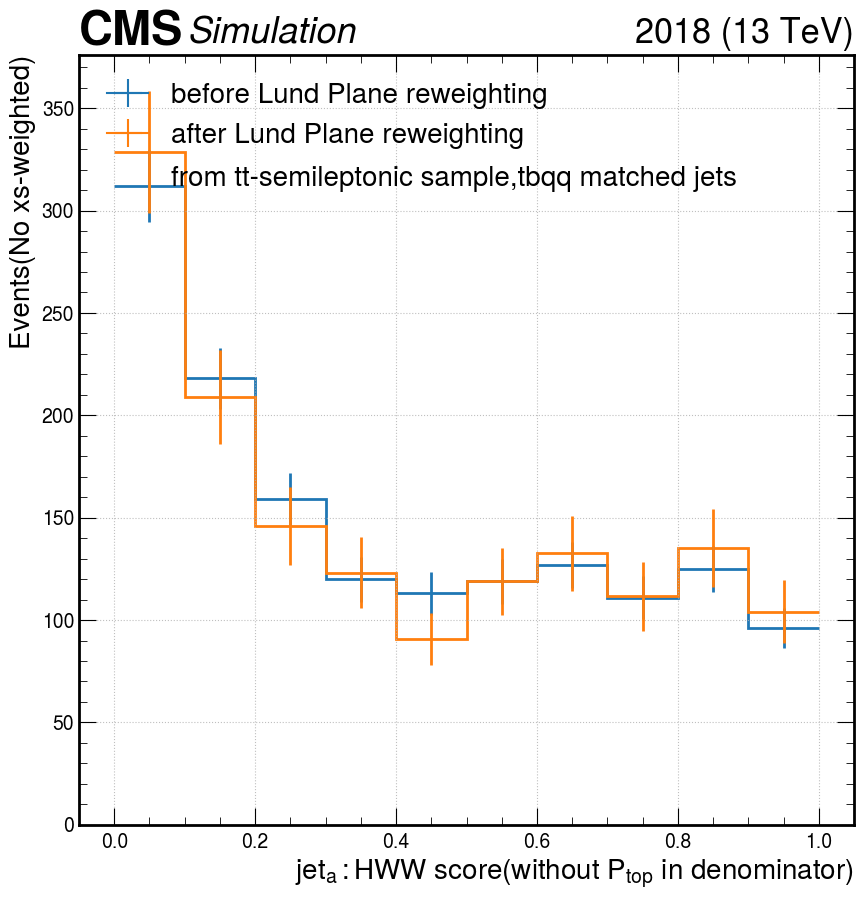

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
max_evts = 1500
#implement CMS plot style functions
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

plt.figure(figsize=(10,10))
ax=plt.gca()
plt.grid()
hep.cms.label(data=False, year="2018", ax=ax, fontname='sans-serif')
%matplotlib inline
#step1: plot 

# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='before reweighting',density=True);
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='after reweighting', weights=eventsEventsID3Prongs4Prongs["LP_weight"],density=True);
nbins, x_min, x_max = 10, 0, 1.0
hist_before = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_before.fill(HWWJets_tagger_score[:max_evts])
hist_before_value = hist_before.view().value
hist_before_err = np.sqrt(hist_before.view().variance)
hist_after = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_after.fill(HWWJets_tagger_score[:max_evts],weight=LP_weights[:max_evts])
hist_after_value = hist_after.view().value
hist_after_err = np.sqrt(hist_after.view().variance)
bins = hist_before.axes[0].edges


hep.histplot(hist_before_value,    bins=bins, yerr=hist_before_err, label= 'before Lund Plane reweighting', lw = 2,edges = False, histtype="step")
hep.histplot(hist_after_value,     bins=bins, yerr=hist_after_err,  label= 'after Lund Plane reweighting', lw = 2,edges = False, histtype="step")


plt.legend(loc='upper left',frameon=False,fontsize=20)
y_min,y_max = plt.gca().get_ylim()
plt.text(0.08, 0.83*y_max, "from tt-semileptonic sample,tbqq matched jets", fontsize=20)
# plt.xlabel(r'$H_{qqqq} / (H_{qqqq} + QCD + Top)$')
plt.xlabel(r'$jet_{a}:HWW\ score(without\ P_{top}\ in\ denominator)$', fontsize=20, ha='right', x=1)
plt.ylabel('Events(No xs-weighted)',fontsize=20, ha='right', y=1)
plt.savefig(f"TaggerDistribution_2018_ttbar_tbqq.pdf", bbox_inches='tight')
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


### Next for tlqq matching and SFs calculation

In [ ]:
events_lep = events_3[top_match_dict["tlqq_matched"].astype(bool)]
events_lep

<NanoEventsArray [<event 1:376716:376715707>, ... ] type='596 * event'>

In [ ]:
tlqq_jet = leading_fatjet[top_match_dict["tlqq_matched"].astype(bool)]

In [ ]:
# four vector for tlqq jet
tlqq_jet_4vec = np.array(np.stack((np.array(tlqq_jet.pt), np.array(tlqq_jet.eta),np.array(tlqq_jet.phi),np.array(tlqq_jet.mass)), axis=1))
tlqq_jet_4vec[1]

array([ 6.4800000e+02, -4.7253418e-01, -3.1231689e-01,  1.6212500e+02],
      dtype=float32)

In [ ]:
len(tlqq_jet)

596

In [ ]:
len(top_match_dict["tlqq_matched"])

20973

### Next for tlqq eta-phi 2 quarks

In [ ]:
eta_2q = np.array(had_ws_children.eta[:, :2])[top_match_dict["tlqq_matched"].astype(bool)]
phi_2q = np.array(had_ws_children.phi[:, :2])[top_match_dict["tlqq_matched"].astype(bool)]

In [ ]:
gen_parts_eta_phi_tlqq_2q = np.array(np.dstack((eta_2q,phi_2q)))

### get tlqq jet idx in each event

In [ ]:
eventsScoreFatjet = events_lep
tagger_scores = eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv1c
#get maximum tagger score jet index
tlqq_jet_idx = ak.argmax(tagger_scores, axis=1)


In [ ]:
tlqq_jet_idx

<Array [0, 0, 1, 0, 2, 0, ... 1, 1, 0, 0, 1, 0] type='596 * ?int64'>

### Get FatJetPFCands 4-vector, up to 150 length to suit the input of Oz's function

In [ ]:
# get all the FatJetPFCands according to the jet_idx, and get PF_idx
tlqq_FatJetPFCands = (events_lep.FatJetPFCands.jetIdx == tlqq_jet_idx)
tlqq_FatJetPFCands_pFCandsIdx = events_lep.FatJetPFCands.pFCandsIdx[tlqq_FatJetPFCands]
# at last, get PFCands 4-vector according to the PF_idx in last step


In [ ]:
tlqq_FatJetPFCands_pFCandsIdx

<Array [[10, 26, 29, 36, ... 225, 227, 202]] type='596 * option[var * int32[para...'>

In [ ]:
pt_array =   ak.Array(events_lep.PFCands.pt)
eta_array =  ak.Array(events_lep.PFCands.eta)
phi_array =  ak.Array(events_lep.PFCands.phi)
mass_array = ak.Array(events_lep.PFCands.mass)

### Need to clean PFCands with dR(l,pf)<0.2

In [ ]:
lep_eta_uncut = np.array(lep_leps.eta)
lep_phi_uncut = np.array(lep_leps.phi)

In [ ]:
lep_eta = lep_eta_uncut[top_match_dict["tlqq_matched"].astype(bool)]
lep_phi = lep_phi_uncut[top_match_dict["tlqq_matched"].astype(bool)]


In [ ]:
#this is because the length of PFCands can be up to 409, so we pad to target = 500
pf_eta = pad_val(eta_array, target = 500, axis = 1, value = 0)
pf_phi = pad_val(phi_array, target = 500, axis = 1, value = 0)
pf_pt = pad_val(pt_array, target = 500, axis = 1, value = 0)
pf_mass = pad_val(mass_array, target = 500, axis = 1, value = 0)

In [ ]:
delta_eta = lep_eta - pf_eta
delta_phi = lep_phi - pf_phi

In [ ]:
delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

In [ ]:
delta_r[0][50:70]

array([5.99388654e-01, 3.13060118e+00, 5.46549322e-01, 9.84495670e-01,
       6.81076877e-01, 5.79924518e-01, 9.02030230e-01, 8.94768729e-01,
       1.09081665e+00, 1.14444964e+00, 1.27891957e-03, 2.86009153e+00,
       3.01528115e+00, 1.13962778e+00, 2.98917455e+00, 3.05805289e+00,
       3.01821456e+00, 3.15145177e+00, 3.21912182e+00, 1.57846855e+00])

In [ ]:
pf_eta_rm_lep = np.copy(pf_eta)
pf_phi_rm_lep = np.copy(pf_phi)
pf_pt_rm_lep = np.copy(pf_pt)
pf_mass_rm_lep = np.copy(pf_mass)

In [ ]:
pf_eta_rm_lep[delta_r<0.2] = 0.0
pf_phi_rm_lep[delta_r<0.2] = 0.0
pf_pt_rm_lep[delta_r<0.2] = 0.0
pf_mass_rm_lep[delta_r<0.2] = 0.0

In [ ]:
np.max(tlqq_FatJetPFCands_pFCandsIdx)

486

In [ ]:
selected_eta  = ak.Array(pf_eta_rm_lep)[tlqq_FatJetPFCands_pFCandsIdx]
selected_phi  = ak.Array(pf_phi_rm_lep)[tlqq_FatJetPFCands_pFCandsIdx]
selected_pt   = ak.Array(pf_pt_rm_lep)[tlqq_FatJetPFCands_pFCandsIdx]
selected_mass = ak.Array(pf_mass_rm_lep)[tlqq_FatJetPFCands_pFCandsIdx]

In [ ]:
# pad the selected 4-vec array up to length of 150 to match the Lund Plane input
selected_pt_padded = pad_val(selected_pt,150,0,1,True)
selected_eta_padded = pad_val(selected_eta,150,0,1,True)
selected_phi_padded = pad_val(selected_phi,150,0,1,True)
selected_mass_padded = pad_val(selected_mass,150,0,1,True)

In [ ]:
pf_cands_px = selected_pt_padded * np.cos(selected_phi_padded)
pf_cands_py = selected_pt_padded * np.sin(selected_phi_padded)
pf_cands_pz = selected_pt_padded * np.sinh(selected_eta_padded)
pf_cands_E = np.sqrt(pf_cands_px**2 + pf_cands_py**2 + pf_cands_pz**2 + selected_mass_padded**2)

In [ ]:
pf_cands_pxpypzE_tlqq = np.dstack((pf_cands_px,pf_cands_py,pf_cands_pz,pf_cands_E))

In [ ]:
print(len(pf_cands_pxpypzE_tlqq[100]))

150


### final check the input information

In [ ]:
#not all these 3 input array are without Hlvqq_cut
print(len(gen_parts_eta_phi_tlqq_2q))
print(len(pf_cands_pxpypzE_tlqq))
print(len(tlqq_jet_4vec))

596
596
596


### Next compute tagger score

In [ ]:
tagger_scores = leading_fatjet
tagger_scores = leading_fatjet.inclParTMDV1_probHWqqWev0c + leading_fatjet.inclParTMDV1_probHWqqWev1c + leading_fatjet.inclParTMDV1_probHWqqWmv0c + leading_fatjet.inclParTMDV1_probHWqqWmv1c + leading_fatjet.inclParTMDV1_probHWqqWtauev0c + leading_fatjet.inclParTMDV1_probHWqqWtauev1c + leading_fatjet.inclParTMDV1_probHWqqWtauhv0c + leading_fatjet.inclParTMDV1_probHWqqWtauhv1c + leading_fatjet.inclParTMDV1_probHWqqWtaumv0c + leading_fatjet.inclParTMDV1_probHWqqWtaumv1c
tlqq_tagger_score = tagger_scores[top_match_dict["tlqq_matched"].astype(bool)]

In [ ]:
tlqq_tagger_score

<Array [0.00206, 0.875, ... 0.254, 0.0429] type='596 * ?float32'>

### note that we also have topology like tlbqq, so 2-3 quarks inside the jet

In [ ]:
#TODO

### Calculate SFs and weights

In [ ]:
import sys, os
sys.path.insert(0, '')
sys.path.append("/home/pku/zhaoyz/Higgs/LundReweighting")
from utils.LundReweighter import *
from utils.Utils import *
""" An example how to use the Lund Plane reweighting  code """

######################## Setup 

#Input file 
fname = "/home/pku/zhaoyz/Higgs/LundReweighting/data/example_signal.h5"
#File containing data/MC Lund Plane ratio
f_ratio_name = '/home/pku/zhaoyz/Higgs/LundReweighting/data/ratio_2018.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset, "Dataset" class defined in Utils.py
# d = Dataset(f_sig, dtype = 1)
# d.compute_obs() #there may be some dedicated variables inside the .h5 file

#The cut we will compute a SF for 'tau21 < 0.34'
tag_obs = 'tau21'
score_thresh = 0.975


#nominal data/MC Lund plane ratio (3d histogram)
h_ratio = f_ratio.Get("ratio_nom")
#systematic variations
h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
#MC ratio of b to light quarks
b_light_ratio = f_ratio.Get("h_bl_ratio")


#directory of pt extrapolation fits
f_ratio.cd('pt_extrap')
rdir = ROOT.gDirectory #get the present working directory and give it to rdir

#Main class for reweighting utilities
LP_rw = LundReweighter(pt_extrap_dir = rdir)

max_evts = 590

# score = getattr(d, tag_obs)[:max_evts]
score_cut = ((tlqq_tagger_score >= 0.6) & (tlqq_tagger_score <= 0.7))
# score_cut = (tlqq_tagger_score > 0.9)
score_cut = score_cut[:max_evts]


#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


################### Compute reweighting factors

#PF candidates in the AK8 jet
# pf_cands = d.get_masked("jet1_PFCands").astype(np.float64)[:max_evts]
pf_cands = pf_cands_pxpypzE_tlqq[:max_evts]
#Generator level quarks from hard process

# gen_parts = d.get_masked('gen_info')[:max_evts]
gen_parts_eta_phi = gen_parts_eta_phi_tlqq_2q[:max_evts]
# gen_parts_pdg_ids = gen_parts[:,:,3]

B_PDG_ID = 5

# ak8_jets = d.get_masked('jet_kinematics')[:max_evts][:,2:6].astype(np.float64)
ak8_jets = tlqq_jet_4vec[:max_evts]

#Nominal event weights of the MC, assume every event is weight '1' for this example
weights_nom = np.ones(max_evts)

LP_weights = []
LP_weights_sys_up = []
LP_weights_sys_down = []
stat_smeared_weights = []
pt_smeared_weights = []
b_weights_up = []
b_weights_down = []
bad_matches = []


for i,cands in enumerate(pf_cands):
    # if i == 4: break
    # print("now processing:",i)
    #Get the subjets, splittings and checking matching based on PF candidates in the jet and gen-level quarks
    subjets, splittings, bad_match, deltaRs = LP_rw.get_splittings_and_matching(cands, gen_parts_eta_phi[i], ak8_jets[i])
    # print(bad_match)
    # print(deltaRs)
    #Gets the nominal LP reweighting factor for this event and statistical + pt extrapolation toys
    LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
            rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
    #Now get systematic variations
    LP_weight_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
    LP_weight_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)

    LP_weights.append(LP_weight)
    stat_smeared_weights.append(stat_smeared_weight)
    pt_smeared_weights.append(pt_smeared_weight)

    LP_weights_sys_up.append(LP_weight_sys_up)
    LP_weights_sys_down.append(LP_weight_sys_down)
    bad_matches.append(bad_match)



############### Normalize weights to preserve normalization of the MC sample

#The nominal Lund Plane correction event weights
LP_weights = LP_rw.normalize_weights(LP_weights) * weights_nom 

#Toy variations for stat and pt uncertainties
stat_smeared_weights = LP_rw.normalize_weights(stat_smeared_weights) * weights_nom.reshape(max_evts, 1)
pt_smeared_weights = LP_rw.normalize_weights(pt_smeared_weights) * weights_nom.reshape(max_evts,1)

#Systematic up/down variations
LP_weights_sys_up = LP_rw.normalize_weights(LP_weights_sys_up) * weights_nom
LP_weights_sys_down = LP_rw.normalize_weights(LP_weights_sys_down) * weights_nom

############### Compute efficiences and uncertainties


#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom) #TODO

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, better to use corrected efficiency computed separately for each sample rather than a single 'SF'


#Compute efficiency for each of the stat/pt toys
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = stat_smeared_weights[:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = pt_smeared_weights[:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(score_cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(score_cut, weights = weights_up)
    eff_down =  np.average(score_cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down


#Compute efficiency of systematic variations
sys_unc_up, sys_unc_down = get_uncs(score_cut, LP_weights_sys_up, LP_weights_sys_down, eff_rw)
# b_unc_up, b_unc_down = get_uncs(score_cut, b_weights_up, b_weights_down, eff_rw)


#matching uncertainty, taken as a fractional uncertainty on efficiency
bad_match_frac = np.mean(bad_matches)
bad_match_unc = bad_match_frac * eff_rw


############ Results
print("\n\nCalibrated efficiency  is %.3f +/- %.3f  (stat) +/- %.3f (pt) +/- %.3f/%.3f (sys)+/- %.3f (matching)  \n\n"  % 
        (eff_rw, eff_stat_unc, eff_pt_unc, sys_unc_up, sys_unc_down, bad_match_unc))

#next compute the uncertainty about SFs

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom) #TODO

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
print("Now perform SFs information")
SF = eff_rw / eff_nom

print("SF (corrected / nom) %.3f" % (SF))

#propagate statistical and pt extrapolation uncertainties to SF
SF_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) /eff_nom
SF_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std) /eff_nom

#propagate systemetic uncertainty to SF
eff_sys_up =  np.average(score_cut, weights = LP_weights_sys_up)
eff_sys_down =  np.average(score_cut, weights = LP_weights_sys_down)

sys_unc_up = abs(eff_rw - eff_sys_up)
sys_unc_down = abs(eff_rw - eff_sys_down)

SF_sys_unc_up = sys_unc_up/eff_nom
SF_sys_unc_down = sys_unc_down/eff_nom

#calculate bad matching uncertainty directly
SF_match_unc = bad_match_frac * SF

print("\n\nSF is %.3f +/-%.3f(stat) +/-%.3f(pt) +%.3f/-%.3f(sys) +/-%.3f(match) \n\n"  % (SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down, SF_match_unc))
f_ratio.Close()


Nominal efficiency 0.042, Corrected efficiency 0.050, SF (corrected / nom) 1.179
Stat variation toys eff. avg 0.048, std dev 0.008
Pt variation toys eff. avg 0.050, std dev 0.001


Calibrated efficiency  is 0.050 +/- 0.010  (stat) +/- 0.001 (pt) +/- -0.005/0.002 (sys)+/- 0.025 (matching)  


Now perform SFs information
SF (corrected / nom) 1.179


SF is 1.179 +/-0.231(stat) +/-0.018(pt) +0.005/-0.002(sys) +/-0.588(match) 




### Make some new plots

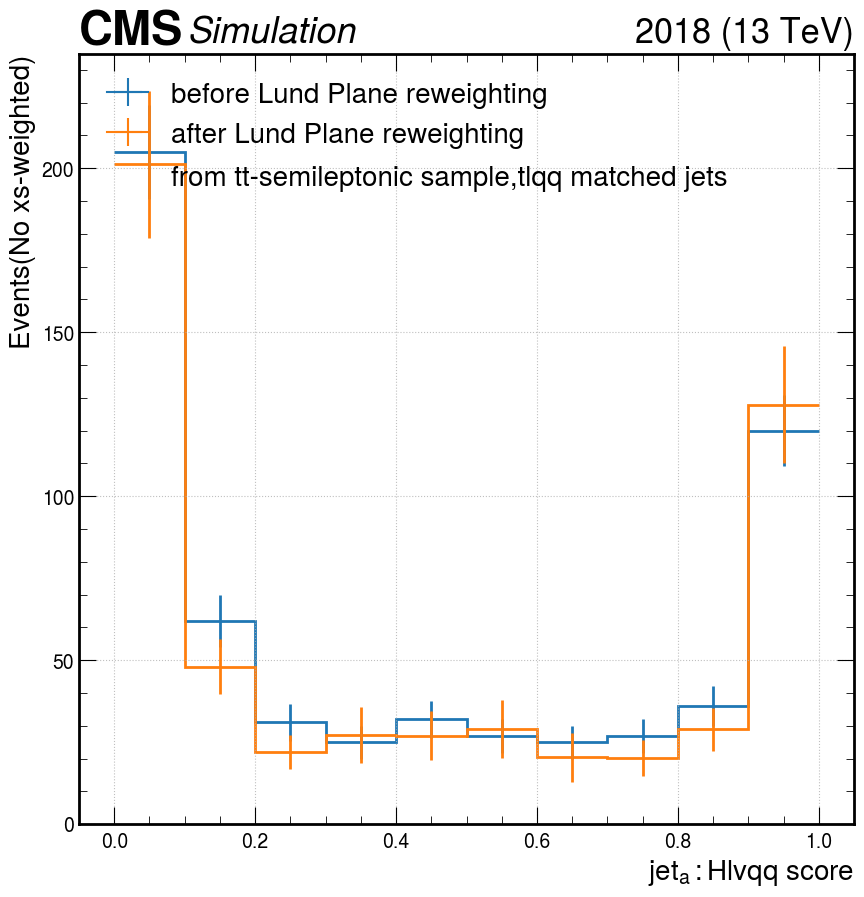

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
max_evts = 590
#implement CMS plot style functions
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

plt.figure(figsize=(10,10))
ax=plt.gca()
plt.grid()
hep.cms.label(data=False, year="2018", ax=ax, fontname='sans-serif')
%matplotlib inline
#step1: plot 

# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='before reweighting',density=True);
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='after reweighting', weights=eventsEventsID3Prongs4Prongs["LP_weight"],density=True);
nbins, x_min, x_max = 10, 0, 1.0
hist_before = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_before.fill(tlqq_tagger_score[:max_evts])
hist_before_value = hist_before.view().value
hist_before_err = np.sqrt(hist_before.view().variance)
hist_after = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_after.fill(tlqq_tagger_score[:max_evts],weight=LP_weights[:max_evts])
hist_after_value = hist_after.view().value
hist_after_err = np.sqrt(hist_after.view().variance)
bins = hist_before.axes[0].edges


hep.histplot(hist_before_value,    bins=bins, yerr=hist_before_err, label= 'before Lund Plane reweighting', lw = 2,edges = False, histtype="step")
hep.histplot(hist_after_value,     bins=bins, yerr=hist_after_err,  label= 'after Lund Plane reweighting', lw = 2,edges = False, histtype="step")


plt.legend(loc='upper left',frameon=False,fontsize=20)
y_min,y_max = plt.gca().get_ylim()
plt.text(0.08, 0.83*y_max, "from tt-semileptonic sample,tlqq matched jets", fontsize=20)
# plt.xlabel(r'$H_{qqqq} / (H_{qqqq} + QCD + Top)$')
plt.xlabel(r'$jet_{a}:Hlvqq\ score$', fontsize=20, ha='right', x=1)
plt.ylabel('Events(No xs-weighted)',fontsize=20, ha='right', y=1)
plt.savefig(f"TaggerDistribution_2018_ttbar_tlqq.pdf", bbox_inches='tight')
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


### Plot pie-chart to show the fraction of different jet types with ttbar samples

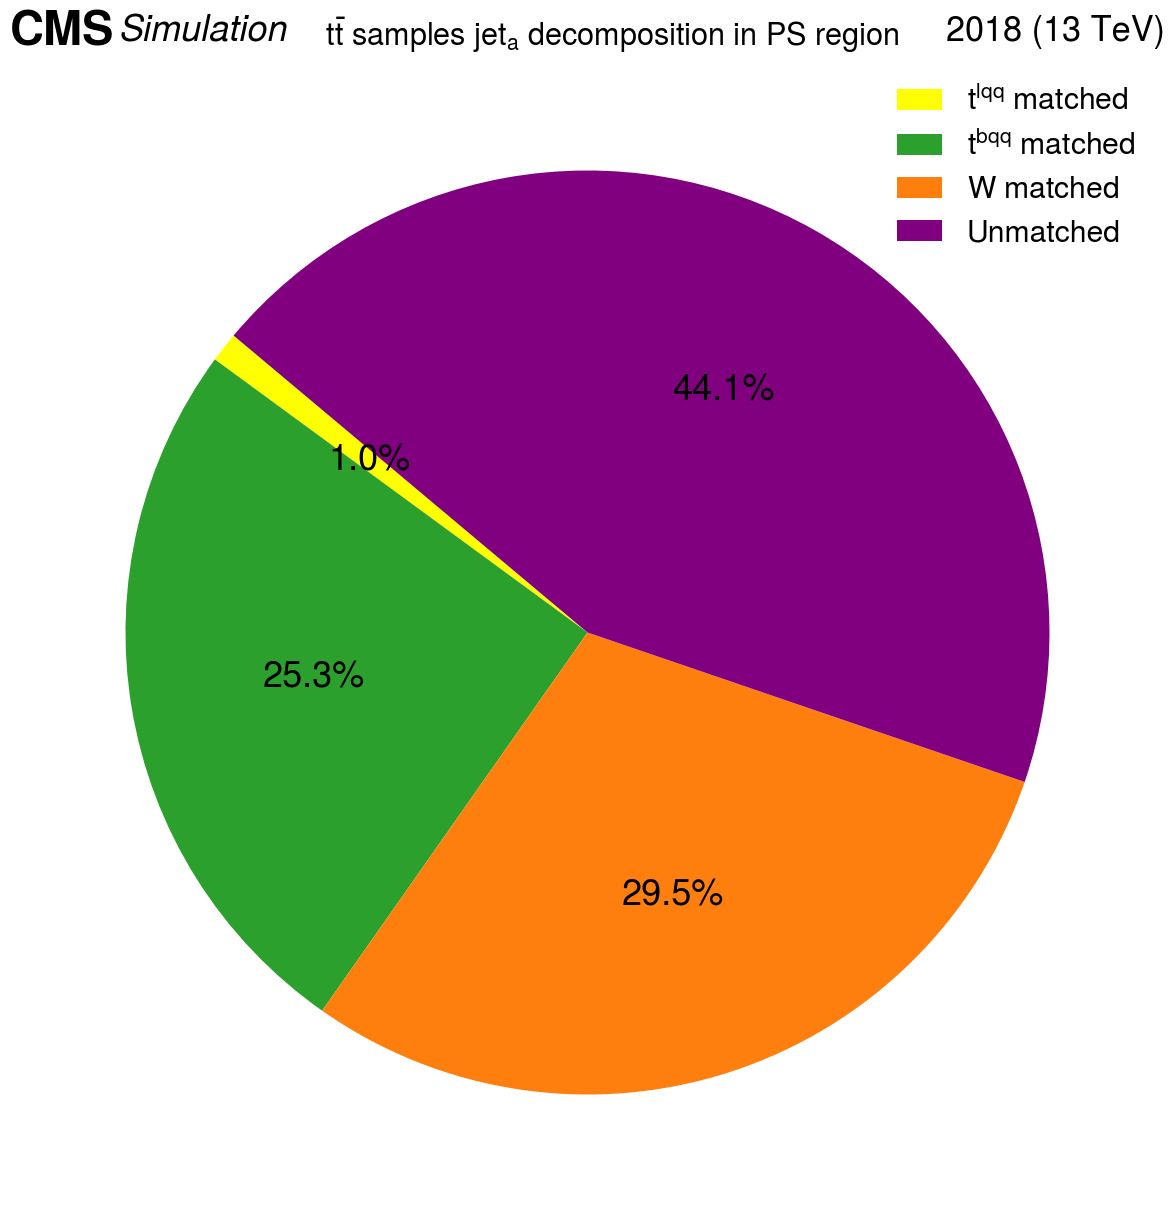

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

plt.figure(figsize=(15,15))
ax=plt.gca()
plt.grid()
hep.cms.label(data=False, year="2018", ax=ax, fontname='sans-serif')
%matplotlib inline

events_pkutree = uproot.lazy({"/data/bond/zhaoyz/SlimmedTree/V5/2018/ttbar_validation_2/Tlqq_matched_v2/Slimmed_ttbar_validation.root":"PKUTree"})
num1_pkutree = np.sum(events_pkutree[events_pkutree["t_a"] == 1]["weight"])
num2_pkutree = np.sum(events_pkutree[events_pkutree["w_a"] == 1]["weight"])
num3_pkutree = np.sum(events_pkutree[events_pkutree["tlqq_a"] == 1]["weight"])
num4_pkutree = np.sum(events_pkutree[(events_pkutree["u_a"] == 1) | (events_pkutree["gKK_g_a"] == 1)]["weight"])

labels = [r'$t^{lqq}\ matched$', r'$t^{bqq}\ matched$', r'$W\ matched$', r'Unmatched']
sizes = [num3_pkutree, num1_pkutree, num2_pkutree, num4_pkutree]

# 颜色
colors = ['#ffff00', '#2ca02c', '#ff7f0e', '#800080']

# 突出显示某个部分（可选）
explode = (0., 0, 0, 0)

# 绘制饼状图
plt.pie(sizes, labels=None, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
plt.legend(labels, loc='upper right')
# 设置图表标题
plt.title(r'$\ \ \ \ \ \ t\bar{t}\ samples\ jet_{a}\ decomposition\ in\ PS\ region$',fontsize = 22)
# title_text = 'Pie Chart Example'
# plt.text(0.5, 0.1, title_text, horizontalalignment='center', verticalalignment='center', fontsize=20, transform=plt.gcf().transFigure)

plt.savefig(f"Piechart_ttbar_deco.pdf", bbox_inches='tight')

# 显示图表
plt.show()

